In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import os
import pickle

plt.style.use(['science', 'grid'])
plt.rc('figure', titlesize = 33, figsize = (21, 7), dpi = 210)
plt.rc('axes', titlesize = 27, labelsize = 21, titlepad = 21)
plt.rc('xtick', labelsize = 17)
plt.rc('ytick', labelsize = 17)

master = '/Users/fomo/Documents/Kaizen/code/physionet/data/CG Macros/'

In [125]:
bio = pd.read_csv(os.path.join(master, 'bio_x_gut.csv'))
microbes = pd.read_csv(os.path.join(master, 'microbes_edit.csv'))
glucose = [i for i in range(1, 50) if i not in [24, 25, 37, 40]]

subjects = set(bio['subject']).intersection(set(microbes['subject'])).intersection(set(glucose))

with open(os.path.join(master, 'subjects.pkl'), 'wb') as f:
    pickle.dump(subjects, f)

bio = bio[bio['subject'].isin(subjects)]
microbes = microbes[microbes['subject'].isin(subjects)]

missing = set(range(1, 50)).difference(set(subjects))

missing

{24, 25, 26, 28, 37, 40, 48}

<Axes: >

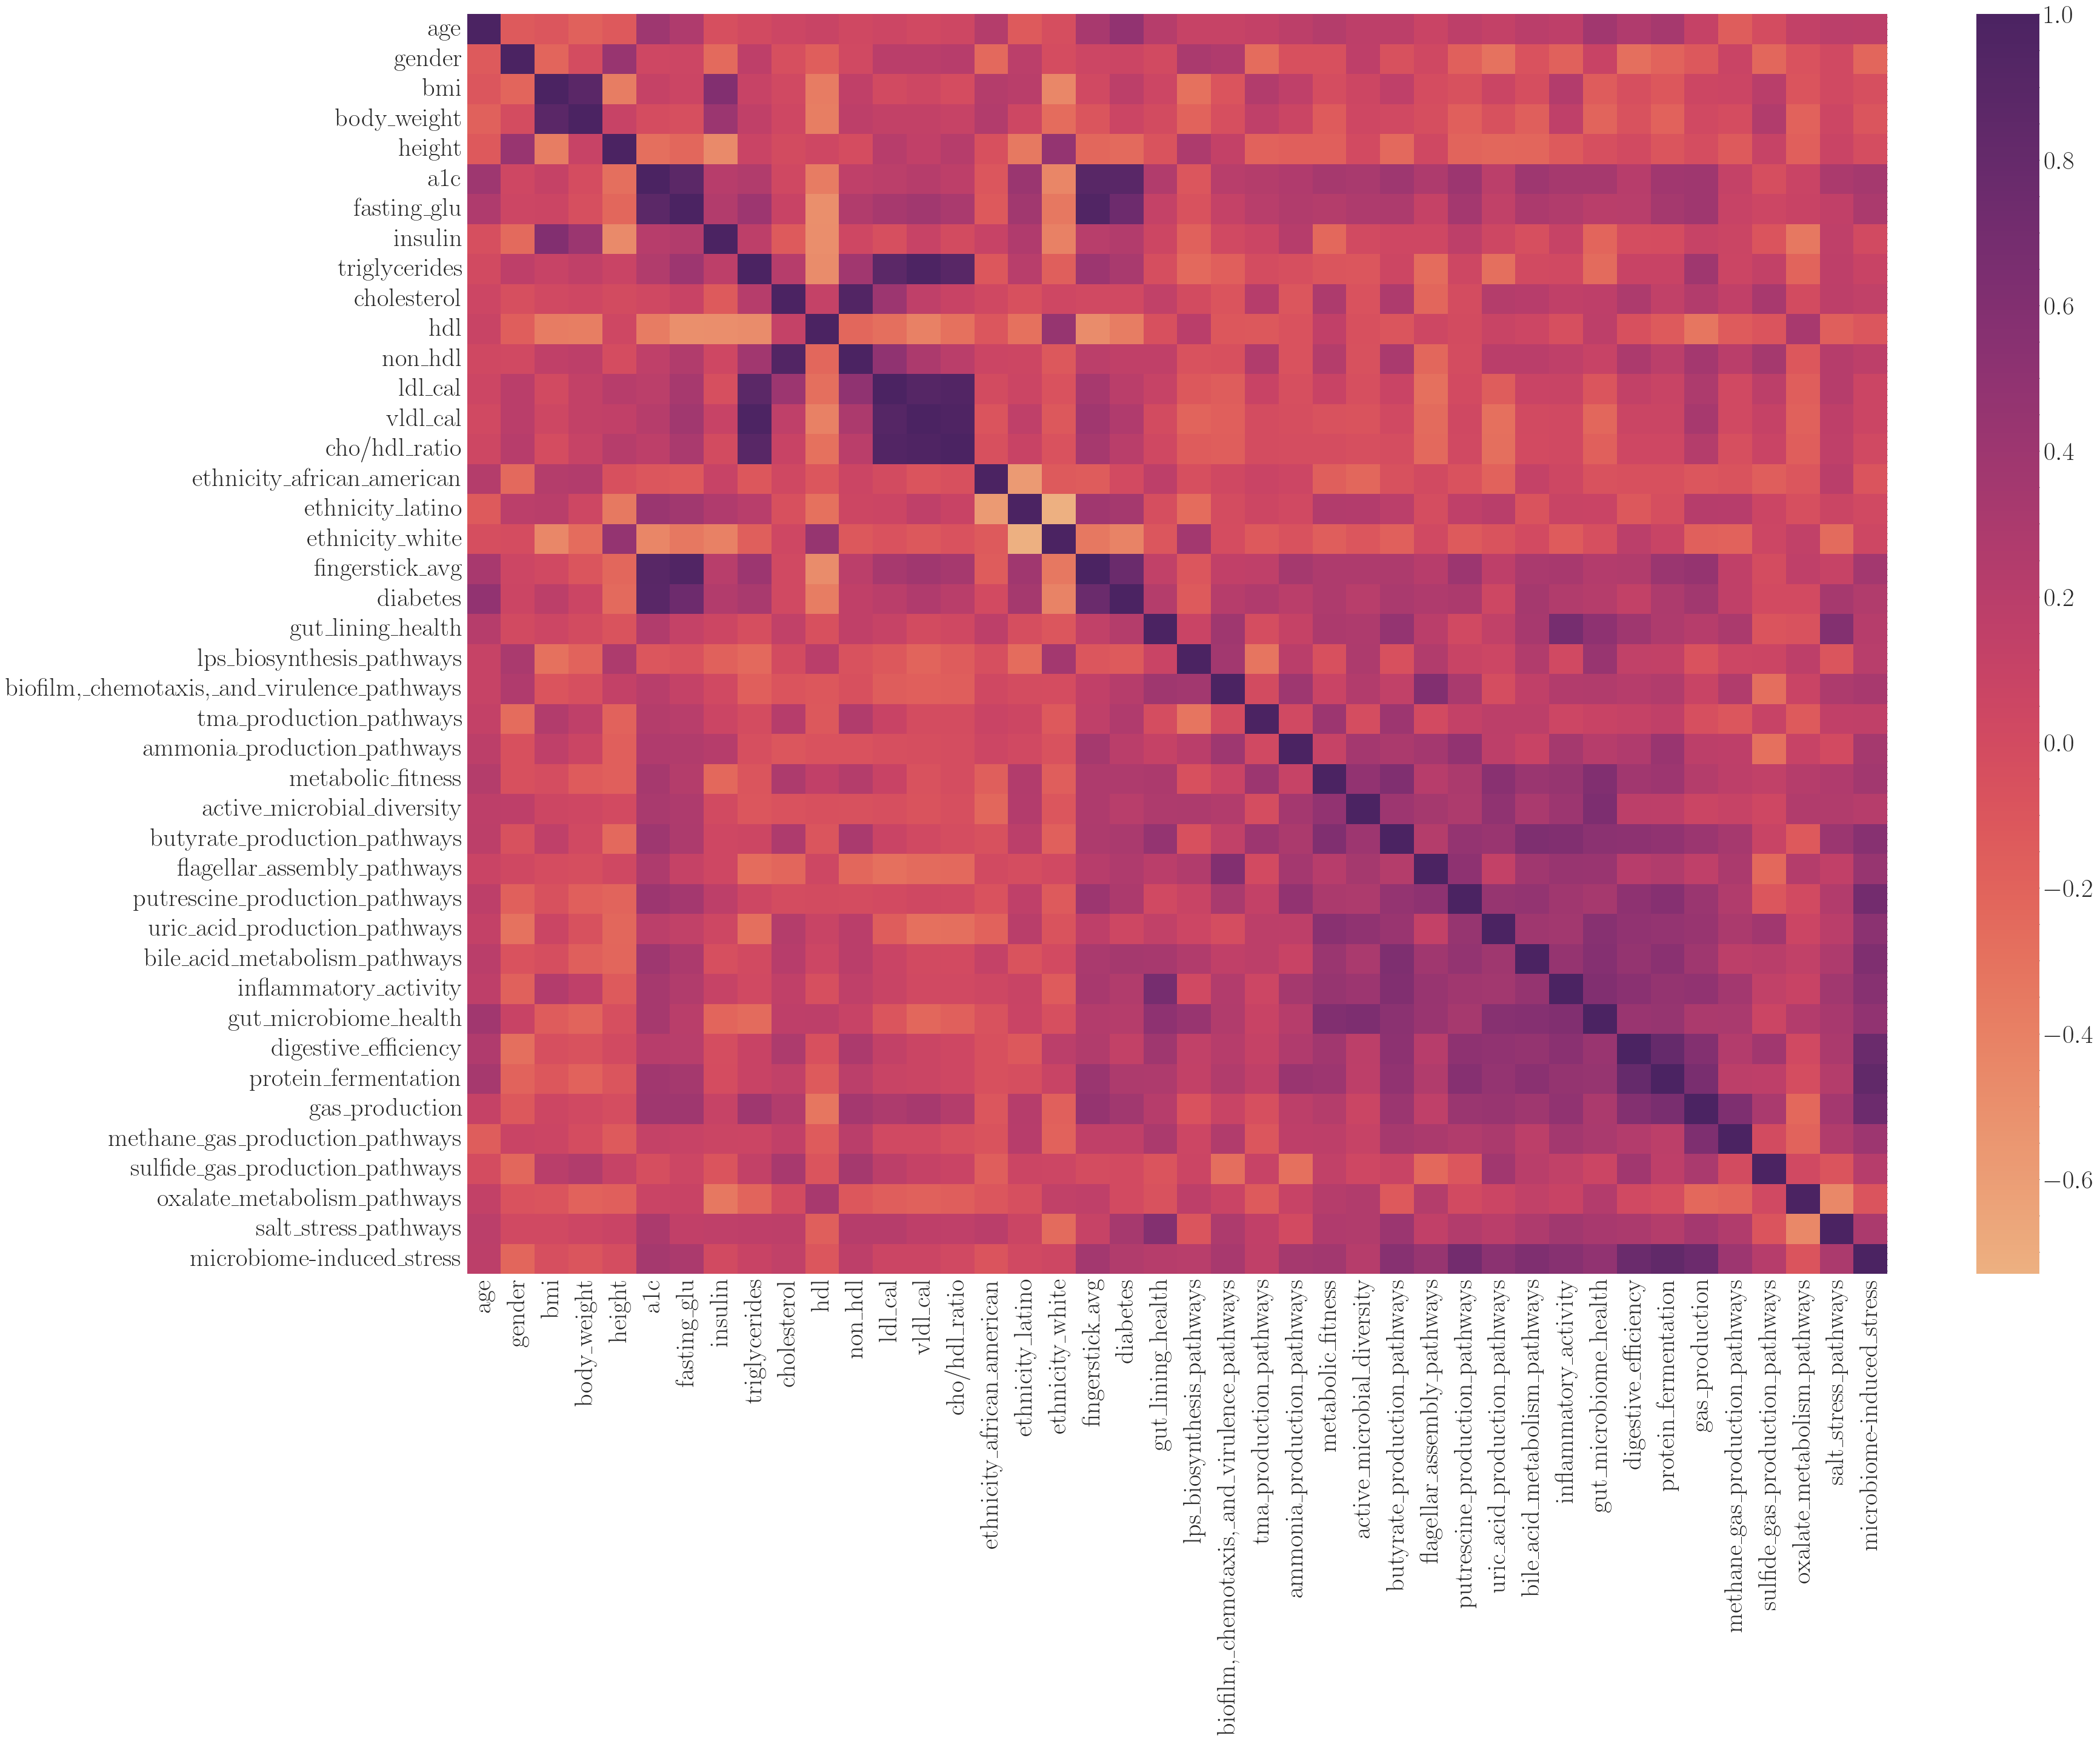

In [117]:
select = bio.drop(['subject'], axis = 1)

plt.figure(figsize = (21, 15), dpi = 180)
sns.heatmap(select.corr(), annot = False, cmap = 'flare')

# Data Preprocessing

In [118]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = bio.drop(['diabetes', 'subject', 'a1c', 'fasting_glu', 'fingerstick_avg', 'insulin'], axis = 1)
# X = bio.drop(['diabetes', 'subject'], axis = 1)

y = bio['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((33, 37), (9, 37))

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# parameter grid for hyperparameter tuning
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
    "solver": ["lbfgs", "newton-cg", "saga"],  # Different solvers for multinomial classification
    "max_iter": [200, 500, 1000]  # Number of iterations for convergence
}


# define logistic regression model with softmax for multiclass
model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_grid, 
    n_iter=5, 
    cv=5, 
    random_state=343
)


random_search.fit(X_train, y_train)  
best_reg = random_search.best_estimator_
y_pred = best_reg.predict(X_test)

print('Best Parameters:', random_search.best_params_)
print(classification_report(y_test, y_pred, target_names=['healthy', 'prediabetes', 'diabetes']))

Best Parameters: {'solver': 'saga', 'max_iter': 1000, 'C': 0.01}
              precision    recall  f1-score   support

     healthy       0.67      1.00      0.80         2
 prediabetes       0.17      1.00      0.29         1
    diabetes       0.00      0.00      0.00         6

    accuracy                           0.33         9
   macro avg       0.28      0.67      0.36         9
weighted avg       0.17      0.33      0.21         9



/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/linea

In [120]:
from xgboost import XGBClassifier

param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.1, 0.3, 0.5, 0.7, 1]
}

model = XGBClassifier()

random_search_xgb = RandomizedSearchCV(
    model, 
    param_distributions=param_grid, 
    n_iter=5, 
    cv=5, 
    random_state=21
)

random_search_xgb.fit(X_train, y_train)
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print('Best Parameters:', random_search_xgb.best_params_)
print(classification_report(y_test, y_pred_xgb, target_names=['healthy', 'prediabetes', 'diabetes']))

Best Parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.5}
              precision    recall  f1-score   support

     healthy       0.67      1.00      0.80         2
 prediabetes       0.00      0.00      0.00         1
    diabetes       0.00      0.00      0.00         6

    accuracy                           0.22         9
   macro avg       0.22      0.33      0.27         9
weighted avg       0.15      0.22      0.18         9



/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

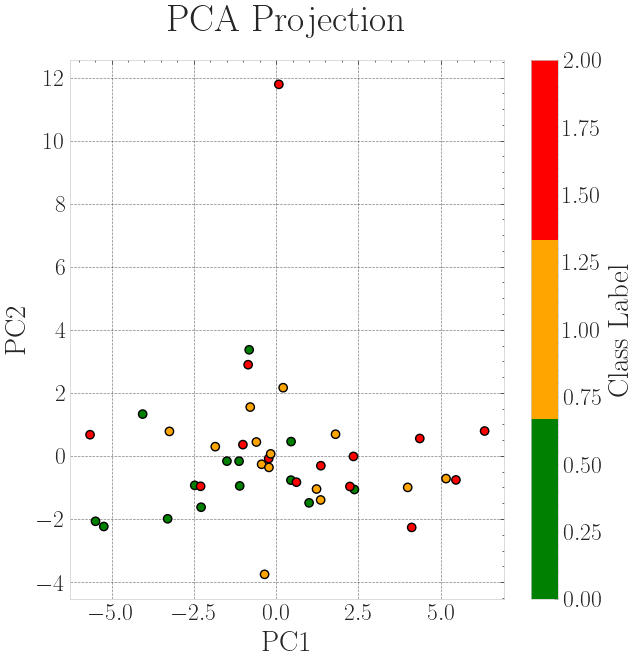

In [121]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

X_bio = bio.drop(['diabetes', 'subject', 'a1c', 'fingerstick_avg', ], axis = 1)

# standardize the features
pca_scaler = StandardScaler()
X_scaled = pca_scaler.fit_transform(X)

# apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# scatter plot
fig = plt.figure(figsize=(7, 7), dpi=100)

# create color map
color_map = ListedColormap(['green', 'orange', 'red'])  # Corrected colormap
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=color_map, edgecolors='k')

# 3D
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap=color_map, edgecolors='k')

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")

# Labels and title
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection")

plt.show()


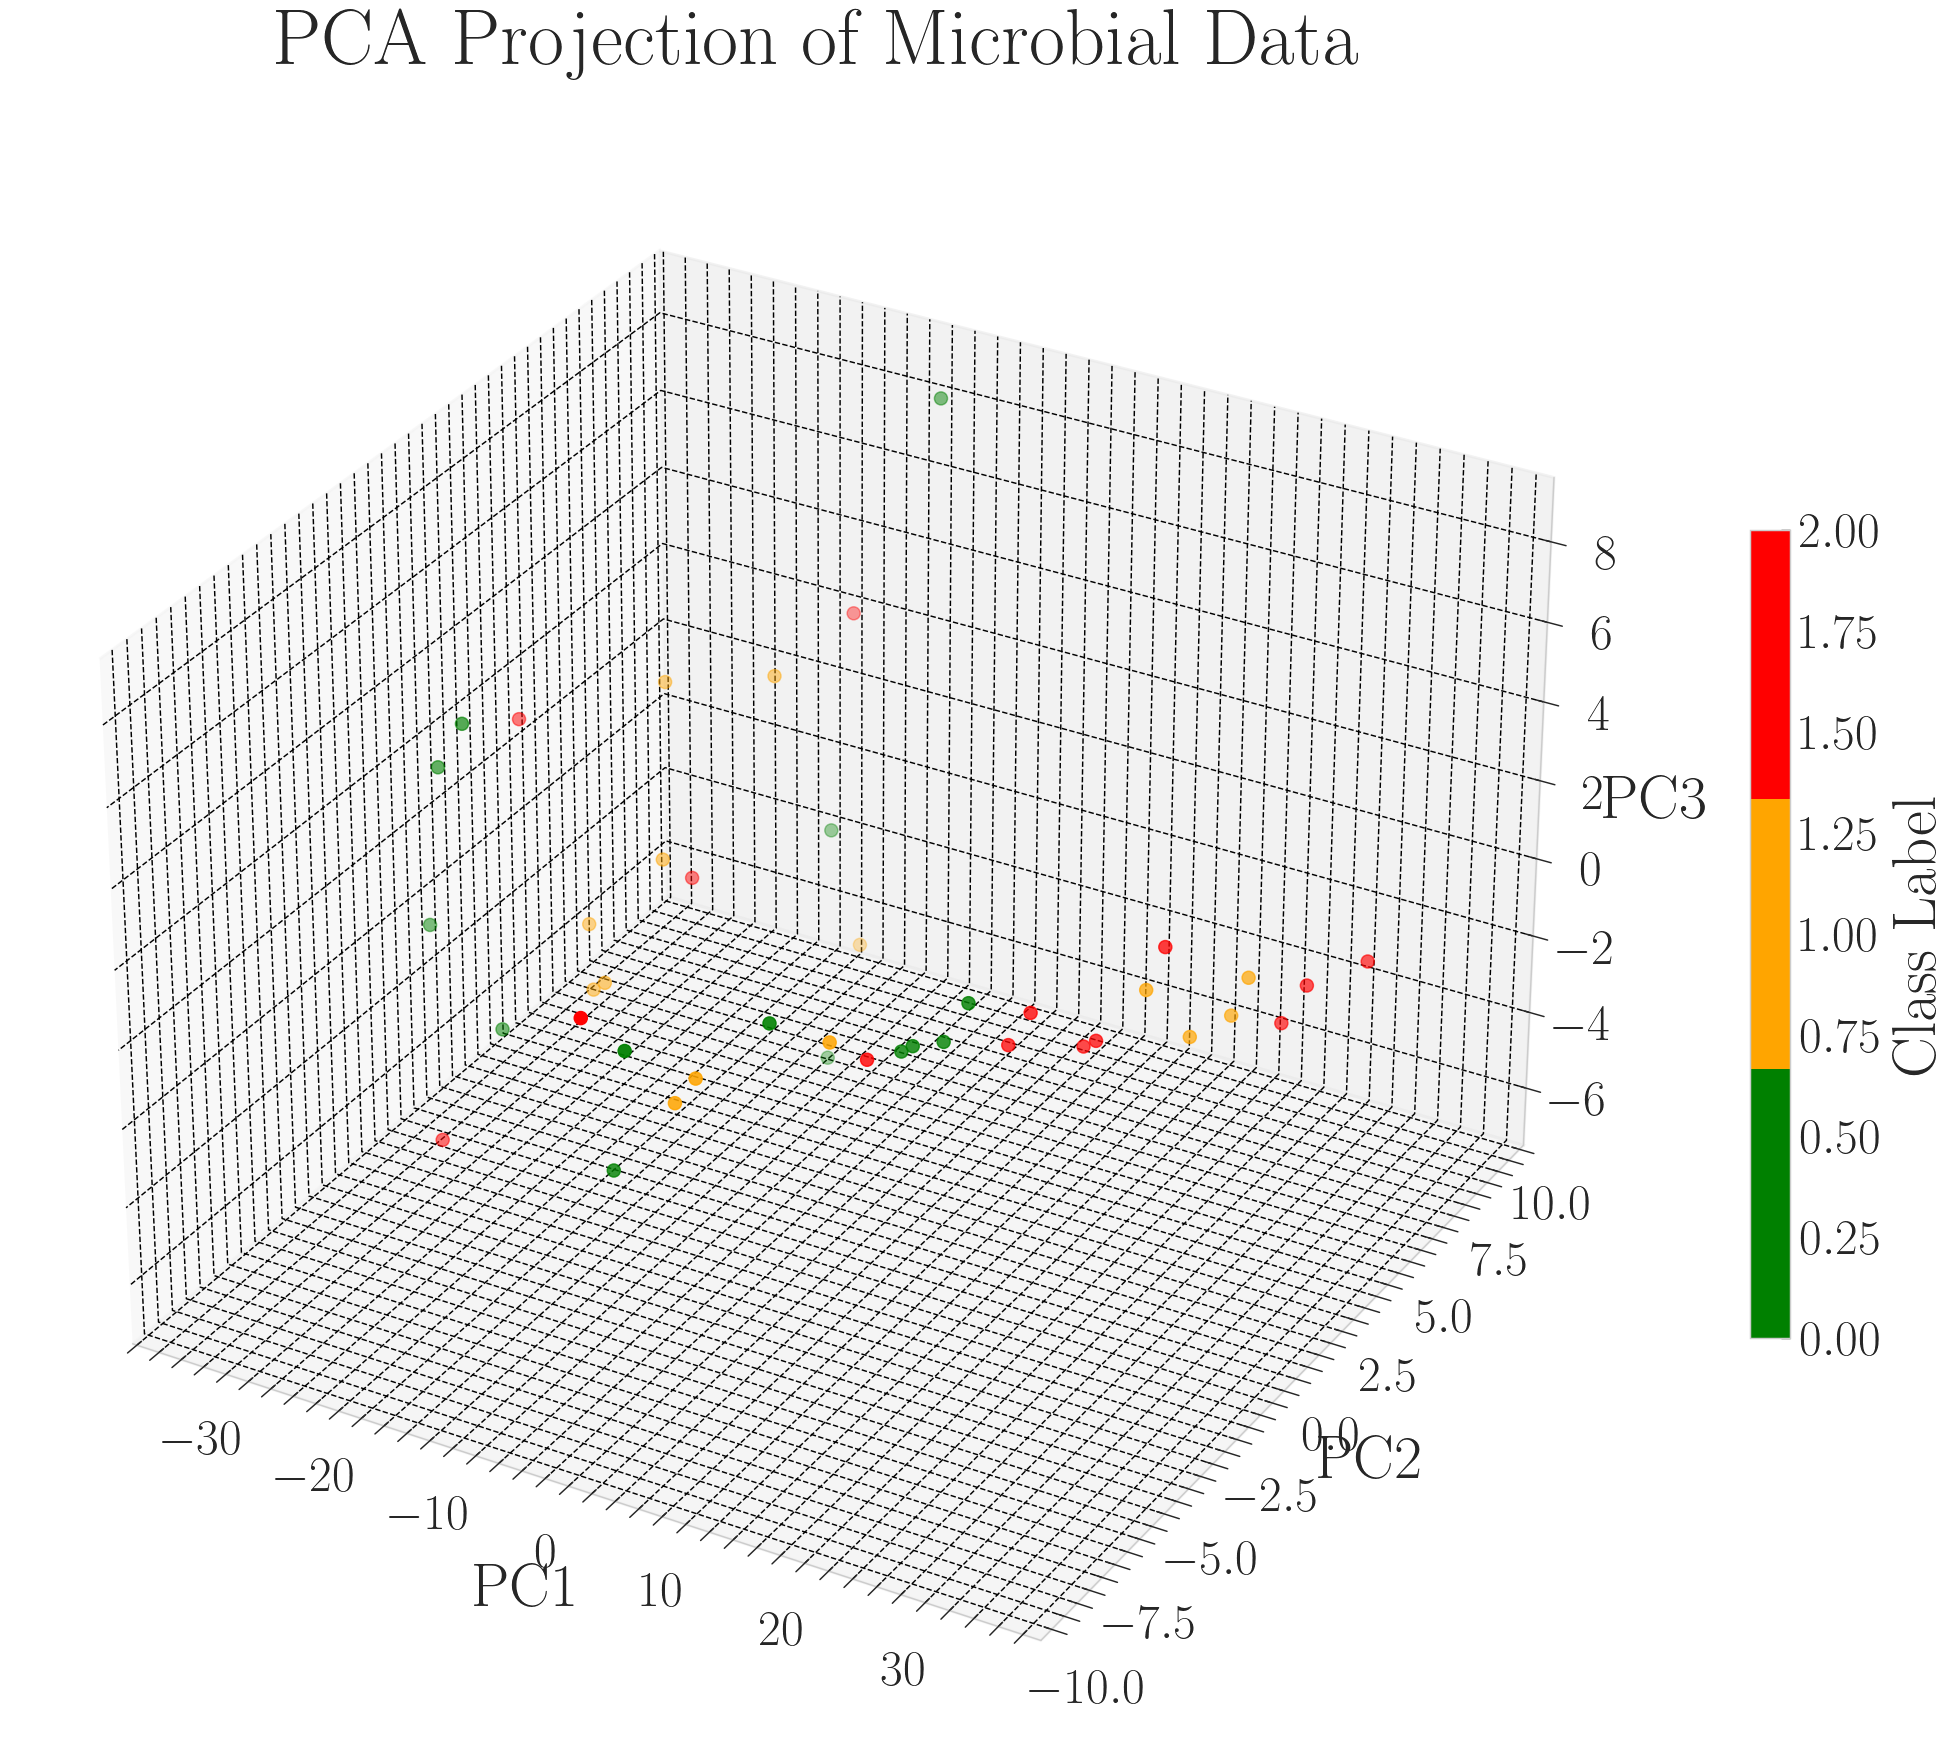

In [131]:
color_map = ListedColormap(['green', 'orange', 'red'])

y_microbe = bio['diabetes']
microbes.dropna(inplace = True)

# Extract labels (ensure correct indexing)
y_microbe = bio['diabetes']

# PCA Transformation
microbe_PCA = PCA(n_components=3)
X_microbe = microbe_PCA.fit_transform(microbes)

# Create Figure
fig = plt.figure(figsize=(15, 10), dpi=210)

# 3D Scatter Plot
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_microbe[:, 0], X_microbe[:, 1], X_microbe[:, 2],
                     c=y_microbe, cmap=color_map, linewidth=0.5)

# Add color bar
cbar = plt.colorbar(scatter, shrink=0.5)
cbar.set_label("Class Label")

# Labels and Title
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA Projection of Microbial Data")

plt.show()


In [133]:
microbes.shape, bio.shape

((42, 1981), (42, 43))